# Qualitative analyses
In this notebook, I include all of my qualitative anlayses/results.

## Setup
To pull from the GitHub repository in Colab:
```
%cd drive/MyDrive/Conservation\ Research/Code/counting-cranes
!git add .
!git stash
!git pull
```
----

In [ ]:
#Mounting Google Drive...
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Will have to restart runtime after running this cell!
!pip install -r "/content/drive/MyDrive/Conservation Research/Code/counting-cranes/requirements.txt"

     |████████████████████████████████| 804.1 MB 2.2 kB/s 
     |████████████████████████████████| 17.4 MB 119 kB/s 
     |████████████████████████████████| 7.1 MB 12.4 MB/s 
     |████████████████████████████████| 2.2 MB 41.6 MB/s 
     |████████████████████████████████| 17.4 MB 164 kB/s 
     |████████████████████████████████| 98 kB 7.2 MB/s 
     |████████████████████████████████| 15.3 MB 164 kB/s 
     |████████████████████████████████| 11.5 MB 12 kB/s 
     |████████████████████████████████| 806 kB 55.1 MB/s 
     |████████████████████████████████| 8.3 MB 41.8 MB/s 
     |████████████████████████████████| 27.4 MB 133 kB/s 
     |████████████████████████████████| 51.0 MB 52 kB/s 
     |████████████████████████████████| 165 kB 71.7 MB/s 
     |████████████████████████████████| 37.1 MB 46 kB/s 
     |████████████████████████████████| 636 kB 46.6 MB/s 
     |████████████████████████████████| 829 kB 75.4 MB/s 
     |████████████████████████████████| 272 kB 56.8 MB/s 
     |████████████

In [1]:
import json

config = json.load(open('/content/drive/MyDrive/Conservation Research/Code/counting-cranes/config.json', 'r'))
DATA_FP = config['data_filepath_colab']
CODE_FP = config['code_filepath_colab']
MODEL_SAVE_FP = config['model_saves_filepath_colab']
SEEDS = config['random_seeds']
FIXED_PERM = config['fixed_data_permutation']
ASPDNET_HYPERPARAMETERS = config['ASPDNet_params']
FASTER_RCNN_HYPERPARAMETERS = config['faster_rcnn_params']
tile_size = tuple(config['tile_size'])

In [2]:
import sys
import os
sys.path.append(CODE_FP) 
sys.path.append(os.path.join(CODE_FP, 'density_estimation'))
sys.path.append(os.path.join(CODE_FP, 'object_detection'))
sys.path.append(os.path.join(CODE_FP, 'density_estimation', 'ASPDNet'))

from bird_dataset import *
from ASPDNet_model import *
from ASPDNet.model import ASPDNet
from faster_rcnn_model import *

import torch
from torch.utils.data import DataLoader
from pytorch_lightning import seed_everything
import torchvision.transforms as transforms
from matplotlib import cm as CM

## General stuff

In [4]:
#Establishing the datasets/dataloaders
bird_dataset_eval_aspdnet = BirdDataset(root_dir = DATA_FP, 
                                        transforms = get_transforms('density_estimation', train = False), 
                                        tiling_method = 'w_o_overlap', 
                                        annotation_mode = 'points', 
                                        tile_size = tile_size,
                                        sigma = 3)
bird_dataset_eval_frcnn = BirdDataset(root_dir = DATA_FP, 
                                      transforms = get_transforms('object_detection', train = False), 
                                      tiling_method = 'w_o_overlap', 
                                      annotation_mode = 'bboxes',
                                      tile_size = tile_size) 

#  recovering the test set
indices = FIXED_PERM
print(f'Indices used: {indices[28 : ]}')
dataset_test_aspdnet = torch.utils.data.Subset(bird_dataset_eval_aspdnet, indices[28 : ])
dataset_test_frcnn = torch.utils.data.Subset(bird_dataset_eval_frcnn, indices[28 : ]) 

#  wrapping datasets in dataloaders
dataloader_test_aspdnet = DataLoader(dataset_test_aspdnet, batch_size = ASPDNET_HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_density) 
dataloader_test_frcnn = DataLoader(dataset_test_frcnn, batch_size = FASTER_RCNN_HYPERPARAMETERS['batch_size'], shuffle = False, collate_fn = collate_tiles_object_detection) 

Indices used: [21, 25, 39, 13, 30, 32, 10, 28, 4, 9, 2, 1]


In [5]:
#Loading both models
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#  ASPDNet...
save_name = 'ASPDNet_no_neg_densities_200_epochs_7.7.2021.ckpt' #TODO: switch w/custom perm model save!
aspdnet = ASPDNet(allow_neg_densities = False).to(device)
pl_model_aspdnet = ASPDNetLightning.load_from_checkpoint(os.path.join(MODEL_SAVE_FP, 'ASPDNet', save_name), model = aspdnet)
pl_model_aspdnet.model.eval()

#  Faster R-CNN... 
save_name = 'faster_rcnn_custom_permutation_7.30.2021.pth'
frcnn = get_faster_rcnn(backbone = 'ResNet50', num_classes = 2, **FASTER_RCNN_HYPERPARAMETERS['constructor_hyperparams']).to(device) 
frcnn.load_state_dict(torch.load(os.path.join(MODEL_SAVE_FP, 'faster_rcnn', 'final_models', save_name)))
pl_model_frcnn = FasterRCNNLightning(model = frcnn)
pl_model_frcnn.model.eval();

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

## **Best/worst tiles**
Seeing where each model struggles the most and least.

### _Faster R-CNN_

In [ ]:
#Saving the worst/best tiles as we go for Faster R-CNN (non-neg tiles use percent error, neg tiles use absolute error)
best_pe = {'img' : None, 'gt_bboxes' : None, 'pred_bboxes' : None, 'PE' : np.inf}
worst_pe = {'img' : None, 'gt_bboxes' : None, 'pred_bboxes' : None, 'PE' : np.NINF}
best_ae = {'img' : None, 'gt_bboxes' : None, 'pred_bboxes' : None, 'AE' : np.inf}
worst_ae = {'img' : None, 'gt_bboxes' : None, 'pred_bboxes' : None, 'AE' : np.NINF}

with torch.no_grad(): #we aren't performing updates, so no grad calculations are necessary... also helps avoid CUDA OOM errors!
  for tiles, targets, _, _ in dataloader_test_frcnn:
    tiles = [t.to(device) for t in tiles]

    preds = pl_model_frcnn(tiles)
    true_bboxes = [t['boxes'] for t in targets]

    for tile, pred_dict, gt in zip(tiles, preds, true_bboxes):
      pred_boxes = pred_dict['boxes']
      
      gt_count = len(gt)
      pred_count = len(pred_boxes)

      if gt_count != 0: #case where not a neg example tile (zero birds)
        pe = 100 * np.absolute(pred_count - gt_count) / gt_count

        if pe < best_pe['PE']:
          best_pe = {'img' : tile, 'gt_bboxes' : gt, 'pred_bboxes' : pred_boxes, 'PE' : pe}
        elif pe > worst_pe['PE']:
          worst_pe = {'img' : tile, 'gt_bboxes' : gt, 'pred_bboxes' : pred_boxes, 'PE' : pe}
      elif gt_count == 0:
        ae = np.absolute(pred_count - gt_count)

        if ae < best_ae['AE']:
          best_ae = {'img' : tile, 'gt_bboxes' : gt, 'pred_bboxes' : pred_boxes, 'AE' : ae}
        elif ae > worst_ae['AE']:
          worst_ae = {'img' : tile, 'gt_bboxes' : gt, 'pred_bboxes' : pred_boxes, 'AE' : ae}

In [ ]:
#Function to handle visualization for bboxes
def visualize_pred_v_gt_BBOXES(error_dict):
  img = (np.moveaxis(error_dict['img'].cpu().numpy(), 0, -1) * 255).astype(np.uint8)
  gt_boxes = error_dict['gt_bboxes'].tolist()
  pred_boxes = error_dict['pred_bboxes'].tolist()

  pil_img_pred = Image.fromarray(np.copy(img).astype(np.uint8))
  draw = ImageDraw.Draw(pil_img_pred)
  for b in pred_boxes:
      draw.rectangle(b, outline = 'red', width = 1)

  pil_img_gt = Image.fromarray(np.copy(img).astype(np.uint8))
  draw = ImageDraw.Draw(pil_img_gt)
  for b in gt_boxes:
      draw.rectangle(b, outline = 'green', width = 1)

  return img, pil_img_pred, pil_img_gt

True count is 51, predicted count is 51, PE is 0.0%


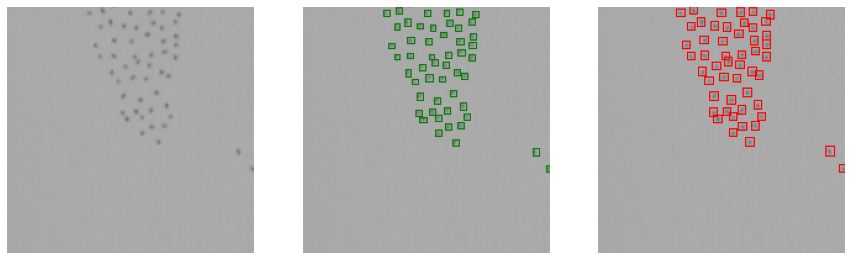

In [ ]:
#Visualizing percent error tiles...
error_dict = best_pe #either "best_pe" or "worst_pe" here!
tile, pil_img_pred, pil_img_gt = visualize_pred_v_gt_BBOXES(error_dict)
print(f'True count is {len(error_dict["gt_bboxes"])}, predicted count is {len(error_dict["pred_bboxes"])}, PE is {error_dict["PE"]}%')

f, axarr = plt.subplots(1, 3, figsize = (15, 10))
axarr[0].imshow(tile)
axarr[1].imshow(pil_img_gt)
axarr[2].imshow(pil_img_pred)
for a in axarr:
    a.axis('off')

True count is 0, predicted count is 0, AE is 0


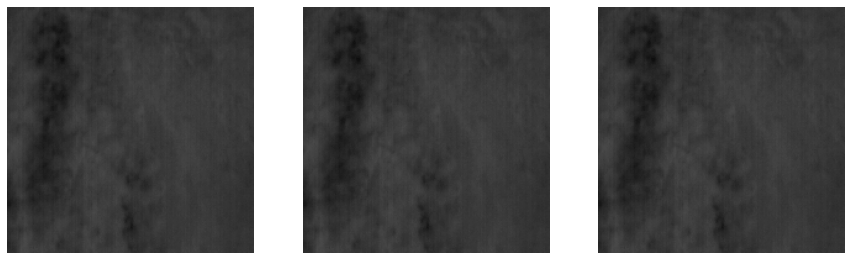

In [ ]:
#Visualizing absolute error tiles...
error_dict = best_ae #either "best_ae" or "worst_ae" here!
tile, pil_img_pred, pil_img_gt = visualize_pred_v_gt_BBOXES(error_dict)
print(f'True count is {len(error_dict["gt_bboxes"])}, predicted count is {len(error_dict["pred_bboxes"])}, AE is {error_dict["AE"]}')

f, axarr = plt.subplots(1, 3, figsize = (15, 10))
axarr[0].imshow(tile)
axarr[1].imshow(pil_img_gt)
axarr[2].imshow(pil_img_pred)
for a in axarr:
    a.axis('off')

### _ASPDNet_

In [ ]:
#Saving the worst/best tiles as we go for ASPDNet (non-neg tiles use percent error, neg tiles use absolute error)
best_pe = {'img' : None, 'gt_den' : None, 'gt_count' : None, 'pred_den' : None, 'PE' : np.inf}
worst_pe = {'img' : None, 'gt_den' : None, 'gt_count' : None, 'pred_den' : None, 'PE' : np.NINF}
best_ae = {'img' : None, 'gt_den' : None, 'gt_count' : None, 'pred_den' : None, 'AE' : np.inf}
worst_ae = {'img' : None, 'gt_den' : None, 'gt_count' : None, 'pred_den' : None, 'AE' : np.NINF}

with torch.no_grad():
  for tiles, gt_densities, counts in dataloader_test_aspdnet:
    tiles = tiles.to(device)

    preds = pl_model_aspdnet(tiles)

    for tile, pred_den, gt_den, gt_count in zip(tiles, list(preds), list(gt_densities), counts):
      pred_count = float(pred_den.sum())

      if gt_count != 0: #case where not a neg example tile (zero birds)
        pe = 100 * np.absolute(pred_count - gt_count) / gt_count

        if pe < best_pe['PE']:
          best_pe = {'img' : tile, 'gt_den' : gt_den, 'gt_count' : gt_count, 'pred_den' : pred_den, 'PE' : pe}
        elif pe > worst_pe['PE']:
          worst_pe = {'img' : tile, 'gt_den' : gt_den, 'gt_count' : gt_count, 'pred_den' : pred_den, 'PE' : pe}
      elif gt_count == 0:
        ae = np.absolute(pred_count - gt_count)

        if ae < best_ae['AE']:
          best_ae = {'img' : tile, 'gt_den' : gt_den, 'gt_count' : gt_count, 'pred_den' : pred_den, 'AE' : ae}
        elif ae > worst_ae['AE']:
          worst_ae = {'img' : tile, 'gt_den' : gt_den, 'gt_count' : gt_count, 'pred_den' : pred_den, 'AE' : ae}

In [ ]:
#Function to handle visualization for bboxes
def visualize_pred_v_gt_DENSITIES(error_dict):
  invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0.],
                                                      std = [ 1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                 transforms.Normalize(mean = [ -0.485, -0.456, -0.406],
                                                      std = [ 1., 1., 1.]),
                                ])
  
  img = invTrans(error_dict['img'])
  img = (np.moveaxis(img.cpu().numpy(), 0, -1) * 255).astype(np.uint8)
  pred_den = error_dict['pred_den'].cpu().squeeze(0)
  gt_den = error_dict['gt_den']

  return img, pred_den, gt_den

True count is 1, predicted count is 4.066141605377197, PE is 306.6141605377197%


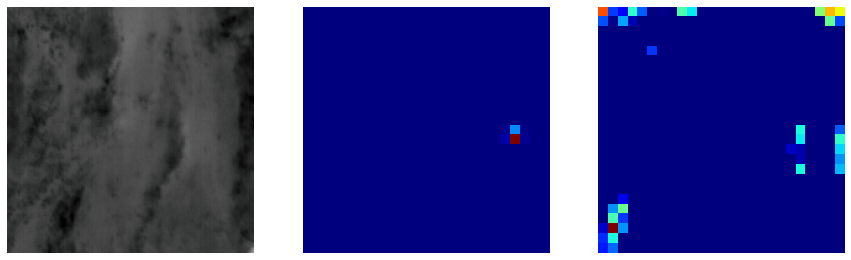

In [ ]:
#Visualizing the percent error tiles...
error_dict = worst_pe
img, pred_den, gt_den = visualize_pred_v_gt_DENSITIES(error_dict)
print(f'True count is {error_dict["gt_count"]}, predicted count is {float(error_dict["pred_den"].sum())}, PE is {error_dict["PE"]}%')

f, axarr = plt.subplots(1, 3, figsize = (15, 10))
axarr[0].imshow(img)
axarr[1].imshow(gt_den, cmap = CM.jet)
axarr[2].imshow(pred_den, cmap = CM.jet)
for a in axarr:
    a.axis('off')

True count is 0, predicted count is 18.488842010498047, AE is 18.488842010498047


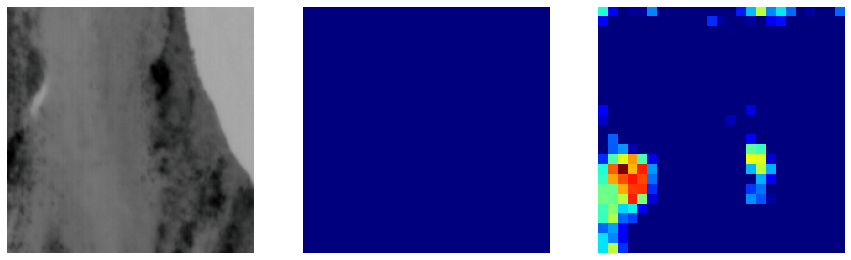

In [ ]:
#Visualizing the absolute error tiles...
error_dict = worst_ae
img, pred_den, gt_den = visualize_pred_v_gt_DENSITIES(error_dict)
print(f'True count is {error_dict["gt_count"]}, predicted count is {float(error_dict["pred_den"].sum())}, AE is {error_dict["AE"]}')

f, axarr = plt.subplots(1, 3, figsize = (15, 10))
axarr[0].imshow(img)
axarr[1].imshow(gt_den, cmap = CM.jet)
axarr[2].imshow(pred_den, cmap = CM.jet)
for a in axarr:
    a.axis('off')

## **Predicting on particular tiles of interest**
**Ideas:**
- _On land:_ `6726`/`6818`/`7167` have easier examples, `4974`/`7106` are slighly harder, `7004` is pretty tough
- _Dense cranes:_ `2510`/`1832`/`2818`/`9152` are relatively dense
- _Ambiguous signatures:_ `1832` has just a few, `9420` has a lot (potentially non-cranes)
- _In flight:_ `2510`/`9420` have a few

---

**Some code to get a look at the grabbed tiles:** `plt.imshow((np.moveaxis(tiles_of_interest[1][0].numpy(), 0, -1) * 255).astype(np.uint8))`

In [64]:
#Pulling out the indices for all test images for tile selection
for i, (_, _, name, _) in enumerate(dataloader_test_frcnn):
  print(f'Index {i} is image {name[0].split("_")[-2]}')

Index 0 is image 6726
Index 1 is image 6818
Index 2 is image 7167
Index 3 is image 4974
Index 4 is image 7070
Index 5 is image 7106
Index 6 is image 2510
Index 7 is image 7004
Index 8 is image 1832
Index 9 is image 2818
Index 10 is image 9420
Index 11 is image 9152


In [6]:
#Predicting on a single tile w/Faster R-CNN
def predict_tiles_of_interest(tile_stuff, model = 'faster_rcnn'):
  tiles = torch.stack([t[0] for t in tile_stuff]) #getting out the images
  tiles = tiles.to(device)
  with torch.no_grad():
    if model == 'faster_rcnn':
      preds = pl_model_frcnn(list(tiles))
    elif model == 'ASPDNet':
      preds = pl_model_aspdnet(tiles)

  gts = [t[1].tolist() if model == 'faster_rcnn' else t[1] for t in tile_stuff] #grabbing the GT bboxes or densities

  if model == 'faster_rcnn':
    for p, t, gt in zip(preds, tiles, gts):
      img = (np.moveaxis(t.cpu().numpy(), 0, -1) * 255).astype(np.uint8)
      pred_boxes = p['boxes'].tolist()

      pil_img_pred = Image.fromarray(np.copy(img).astype(np.uint8))
      draw = ImageDraw.Draw(pil_img_pred)
      for b in pred_boxes:
          draw.rectangle(b, outline = 'red', width = 1)

      pil_img_gt = Image.fromarray(np.copy(img).astype(np.uint8))
      draw = ImageDraw.Draw(pil_img_gt)
      for b in gt:
          draw.rectangle(b, outline = 'green', width = 1)

      f, axarr = plt.subplots(1, 3, figsize = (15, 10))
      axarr[0].imshow(img)
      axarr[1].imshow(pil_img_gt)
      axarr[2].imshow(pil_img_pred)

      axarr[1].set_title(f'Ground Truth: {len(gt)}')
      axarr[2].set_title(f'Predicted: {len(pred_boxes)}')
      for a in axarr:
          a.axis('off')
  elif model == 'ASPDNet':
    counts = [t[2] for t in tile_stuff]
    for p, t, gt, ct in zip(preds, tiles, gts, counts):
      invTrans = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0.],
                                                      std = [ 1 / 0.229, 1 / 0.224, 1 / 0.225]),
                                 transforms.Normalize(mean = [ -0.485, -0.456, -0.406],
                                                      std = [ 1., 1., 1.]),
                                ])
  
      img = invTrans(t)
      img = (np.moveaxis(img.cpu().numpy(), 0, -1) * 255).astype(np.uint8)
      pred_den = p.cpu().squeeze(0)

      f, axarr = plt.subplots(1, 3, figsize = (15, 10))
      axarr[0].imshow(img)
      axarr[1].imshow(gt, cmap = CM.jet)
      axarr[2].imshow(pred_den, cmap = CM.jet)

      axarr[1].set_title(f'Ground Truth: {ct}')
      axarr[2].set_title(f'Predicted: {round(float(pred_den.cpu().sum()), 2)}')
      for a in axarr:
          a.axis('off')

In [55]:
#A basic function to collect the tiles of interest indicated by (parent img #, tile #) tuples
def get_tiles_of_interest(tile_tuples, model_to_use):
  tiles_of_interest = []
  for t in tiles_to_grab:
    if model_to_use == 'faster_rcnn':
      tile_stuff = dataset_test_frcnn[t[0]][t[1]]
      tiles_of_interest.append((tile_stuff[0], tile_stuff[1]['boxes']))
    elif model_to_use == 'ASPDNet':
      tile_stuff = dataset_test_aspdnet[t[0]][t[1]]
      tiles_of_interest.append((tile_stuff[0], tile_stuff[1], tile_stuff[2]))
  
  return tiles_of_interest

In [38]:
#Picking out the model to produce preds for
model_to_use = 'faster_rcnn'

### *Tiles w/birds on land*

In [56]:
#Grabbing some tiles of interest - format here is parent img num, tile in that parent img (w/o overlap)
tiles_to_grab = ((0, 10), #6726
                 (1, 18), #6818 
                 (3, 15), #4974
                 (7, 4))  #7004 

tiles_of_interest = get_tiles_of_interest(tiles_to_grab, model_to_use) #this is tuples of (img, GT) or (img, GT, gt_count) for ASPDNet

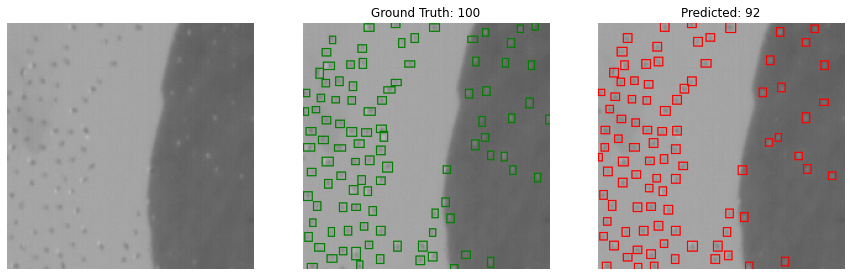

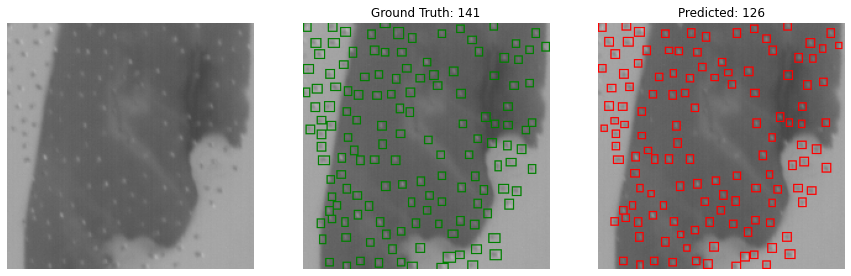

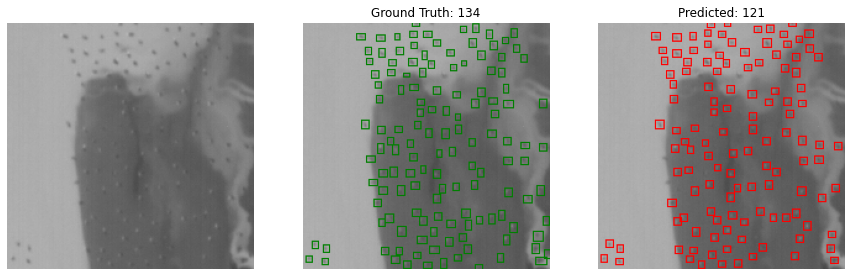

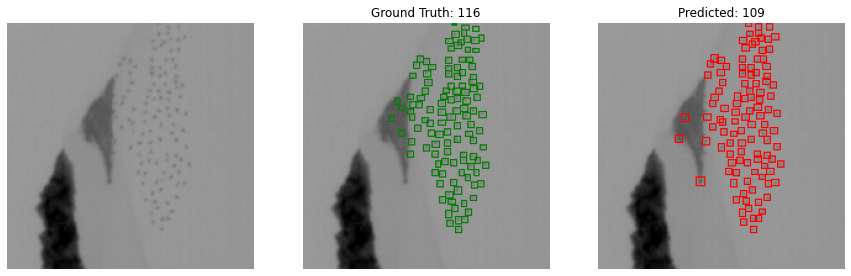

In [57]:
#Checking out how the model does w/these tiles...
predict_tiles_of_interest(tiles_of_interest, model = model_to_use)

### *Tiles w/dense birds*

In [58]:
#Grabbing some tiles of interest
tiles_to_grab = ((6, 15), #2510
                 (9, 25), #2818
                 (8, 1))  #1832

tiles_of_interest = get_tiles_of_interest(tiles_to_grab, model_to_use)

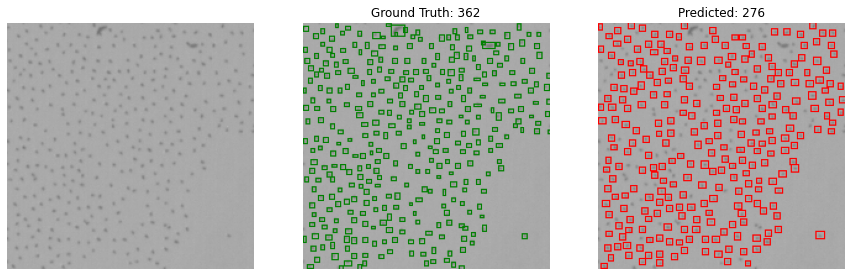

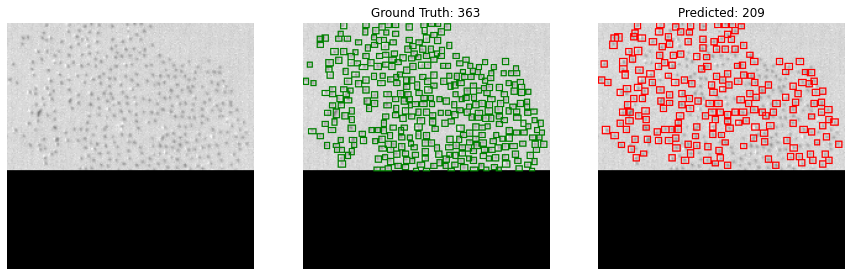

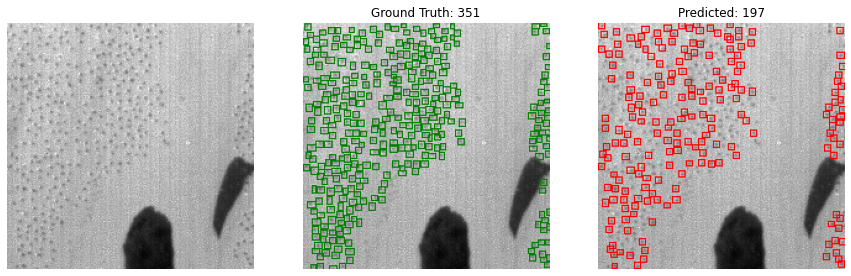

In [59]:
#Checking out how the model does w/these tiles...
predict_tiles_of_interest(tiles_of_interest, model = model_to_use)

### *Tiles w/birds in flight*

In [60]:
#Grabbing some tiles of interest
tiles_to_grab = ((6, 3),   #2510
                 (6, 5),   #2510
                 (10, 10)) #9420          

tiles_of_interest = get_tiles_of_interest(tiles_to_grab, model_to_use)

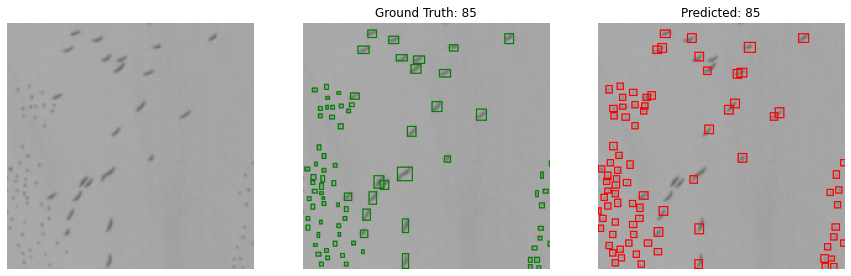

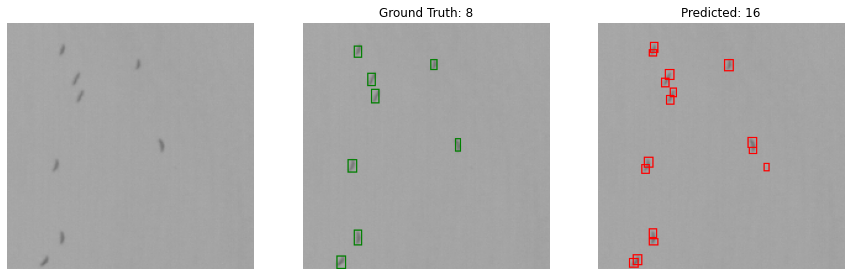

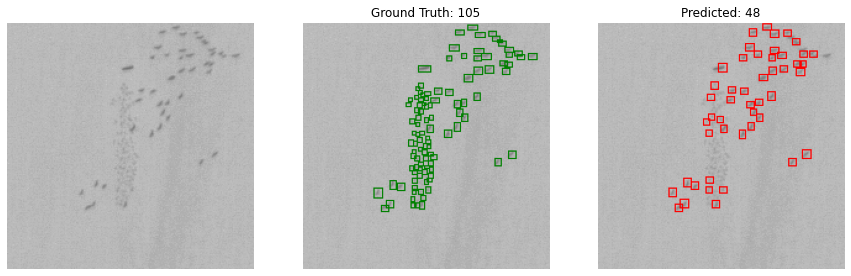

In [61]:
#Checking out how the model does w/these tiles...
predict_tiles_of_interest(tiles_of_interest, model = model_to_use)

### *Tiles that were difficult to annotate/have ambiguous birds*

In [ ]:
#Grabbing some tiles of interest
tiles_to_grab = ((10, 1), #9420
                 (8, 8))  #1832       

tiles_of_interest = get_tiles_of_interest(tiles_to_grab, model_to_use)

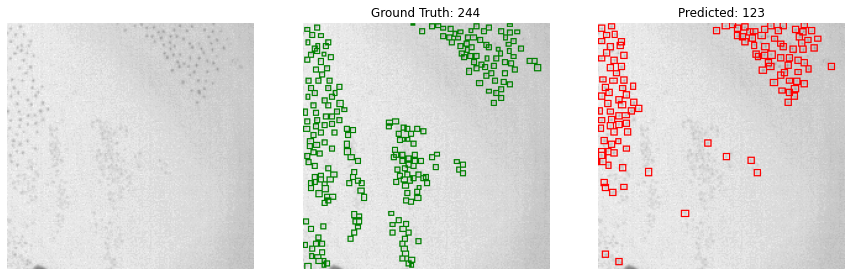

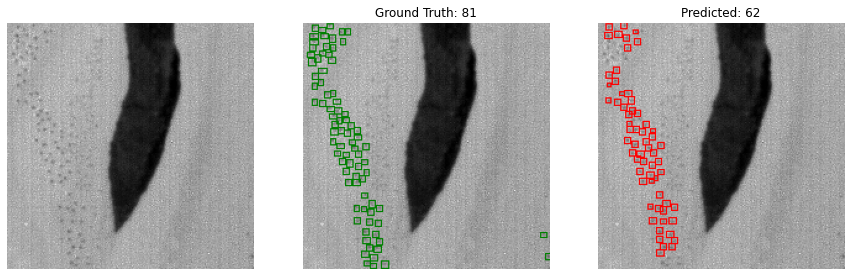

In [70]:
#Checking out how the model does w/these tiles...
predict_tiles_of_interest(tiles_of_interest, model = model_to_use)

### _Non-optimal sensor conditions_
**TODO:** you'll have to make a new dataset for this one and maybe use the `BirdDataset_PREDICTION` version since we don't have annotations!